# Compare double wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
# fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) ) # Before retuning TI
fi_dict = pickle.load( open( "floris_models_4.p", "rb" ) ) # After retuning TI
fi_dict

{'g': (<floris.tools.floris_interface.FlorisInterface at 0x106a9ead0>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x1187a3c10>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x1187ba490>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x1187c20d0>,
  'gray',
  '^',
  'legacy')}

In [3]:
# Make a color dict
color_dict = dict()
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    color_dict[floris_label] = floris_color

# Calculate the power in each case

Make sure now to include yaw angles

In [4]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label
    

    for i, row in df.iterrows():


        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy'):
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        
        fi.calculate_wake(yaw_angles=row.yaw)

        floris_power = np.mean(np.array(fi.get_turbine_power())/1000.)

        sowfa_power = np.mean(row.power)



        result_dict = {'sowfa_power':[sowfa_power],
                       'floris_power':[floris_power],
                       'floris_label':[floris_label],
                       'sowfa_U0':[row.sowfa_U0],
                       'sowfa_TI':[row.sowfa_TI],
                       'yaw':[row.yaw],
                       'layout_x':[row.layout_x],
                       'layout_y':[row.layout_y],
                       'num_turbines':row.num_turbines,
                       'd_spacing':row.d_spacing
                      }

        results_df = results_df.append(pd.DataFrame(result_dict))

results_df.head()

/Users/pfleming/Desktop/git_tools/FLORIS/floris/simulation/wake_velocity/gaussianModels/gauss.py:136: RuntimeWarning: invalid value encountered in sqrt
  C = a1 - np.sqrt(a2 - (n * Ct * cosd(yaw) / (16.0 * gamma(2/n) * np.sign(sigma_tilde) * np.abs(sigma_tilde)**(4/n) ) ) )
/Users/pfleming/Desktop/git_tools/FLORIS/floris/simulation/wake_velocity/gaussianModels/gaussian_model_base.py:330: RuntimeWarning: overflow encountered in power
  return U * C * np.exp( -1 * r**n / (2 * sigma**2) )
/Users/pfleming/Desktop/git_tools/FLORIS/floris/simulation/wake_velocity/gaussianModels/gauss_legacy.py:88: RuntimeWarning: invalid value encountered in sqrt
  C = 1 - np.sqrt(1 - ( Ct * cosd(yaw) / (8.0 * sigma_y * sigma_z / D**2) ) )


,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1504.90,1543.830974,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0
0,1345.35,1354.297744,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0


In [5]:
# Assign a baseline power to each row
baseline = []
baseline_sowfa = []
for i, row in results_df.iterrows():
    yaw = row.yaw
    
    # Find the row that is this rows baseline
    df_sub = results_df[(results_df.layout_x == row.layout_x) & 
                        (results_df.layout_y == row.layout_y) & 
                        (results_df.sowfa_U0 == row.sowfa_U0) & 
                        (results_df.sowfa_TI == row.sowfa_TI) & 
                        (results_df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0) &
                        (results_df.floris_label == row.floris_label)]
    if df_sub.shape[0] == 0:
        baseline.append(np.nan)
        baseline_sowfa.append(np.nan)
    else:
        baseline.append(df_sub.floris_power.values[0])
        baseline_sowfa.append(df_sub.sowfa_power.values[0])

results_df['baseline_floris'] = baseline
results_df['baseline_sowfa'] = baseline_sowfa
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1504.90,1543.830974,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35
0,1345.35,1354.297744,gauss,8.0,0.1,"[0.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35


In [6]:
# Remove missing values
# plt.plot(results_df.baseline_floris.isnull())
print(results_df.shape)
results_df = results_df[~results_df.baseline_floris.isnull()]
print(results_df.shape)

(3072, 12)
(3072, 12)


In [7]:
# drop the baseline cases
print(results_df.shape)
results_df = results_df[results_df.yaw.apply(lambda x: np.max(np.abs(x)))!=0.0]
print(results_df.shape)

(3072, 12)
(2456, 12)


In [8]:
# compute the gains
results_df['sowfa_gain'] = results_df.sowfa_power - results_df.baseline_sowfa
results_df['sowfa_gain_nom'] = 100. * (results_df.sowfa_power - results_df.baseline_sowfa) / results_df.baseline_sowfa
results_df['floris_gain'] = results_df.floris_power - results_df.baseline_floris
results_df['floris_gain_nom'] = 100. * (results_df.floris_power - results_df.baseline_floris) / results_df.baseline_floris

In [9]:
results_df.head()

,sowfa_power,floris_power,floris_label,sowfa_U0,sowfa_TI,yaw,layout_x,layout_y,num_turbines,d_spacing,baseline_floris,baseline_sowfa,sowfa_gain,sowfa_gain_nom,floris_gain,floris_gain_nom
0,1571.35,1541.475533,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90,66.45,4.415576,-2.355441,-0.152571
0,1327.45,1432.336979,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 937.0)",2,5.0,1543.830974,1504.90,-177.45,-11.791481,-111.493995,-7.221904
0,1303.25,1326.137115,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35,-42.10,-3.129297,-28.160630,-2.079353
0,1363.90,1398.096606,gauss,8.0,0.1,"[20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1000.0)",2,5.0,1354.297744,1345.35,18.55,1.378823,43.798862,3.234064
0,1360.70,1307.146134,gauss,8.0,0.1,"[-20.0, 0.0]","(1000.0, 1630.0)","(1000.0, 1063.0)",2,5.0,1542.925884,1577.00,-216.30,-13.715916,-235.779751,-15.281340


In [18]:
%matplotlib

Using matplotlib backend: MacOSX


In [19]:
# Compare the gains at the start
use_nominal = False

if use_nominal:
    sowfa_signal = 'sowfa_gain_nom'
    floris_signal = 'floris_gain_nom'
else:
    sowfa_signal = 'sowfa_gain'
    floris_signal = 'floris_gain'    
g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=4,size=2)
g.map(plt.scatter,sowfa_signal,floris_signal,s=8)
for ax in g.axes.flatten():
    ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
            [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


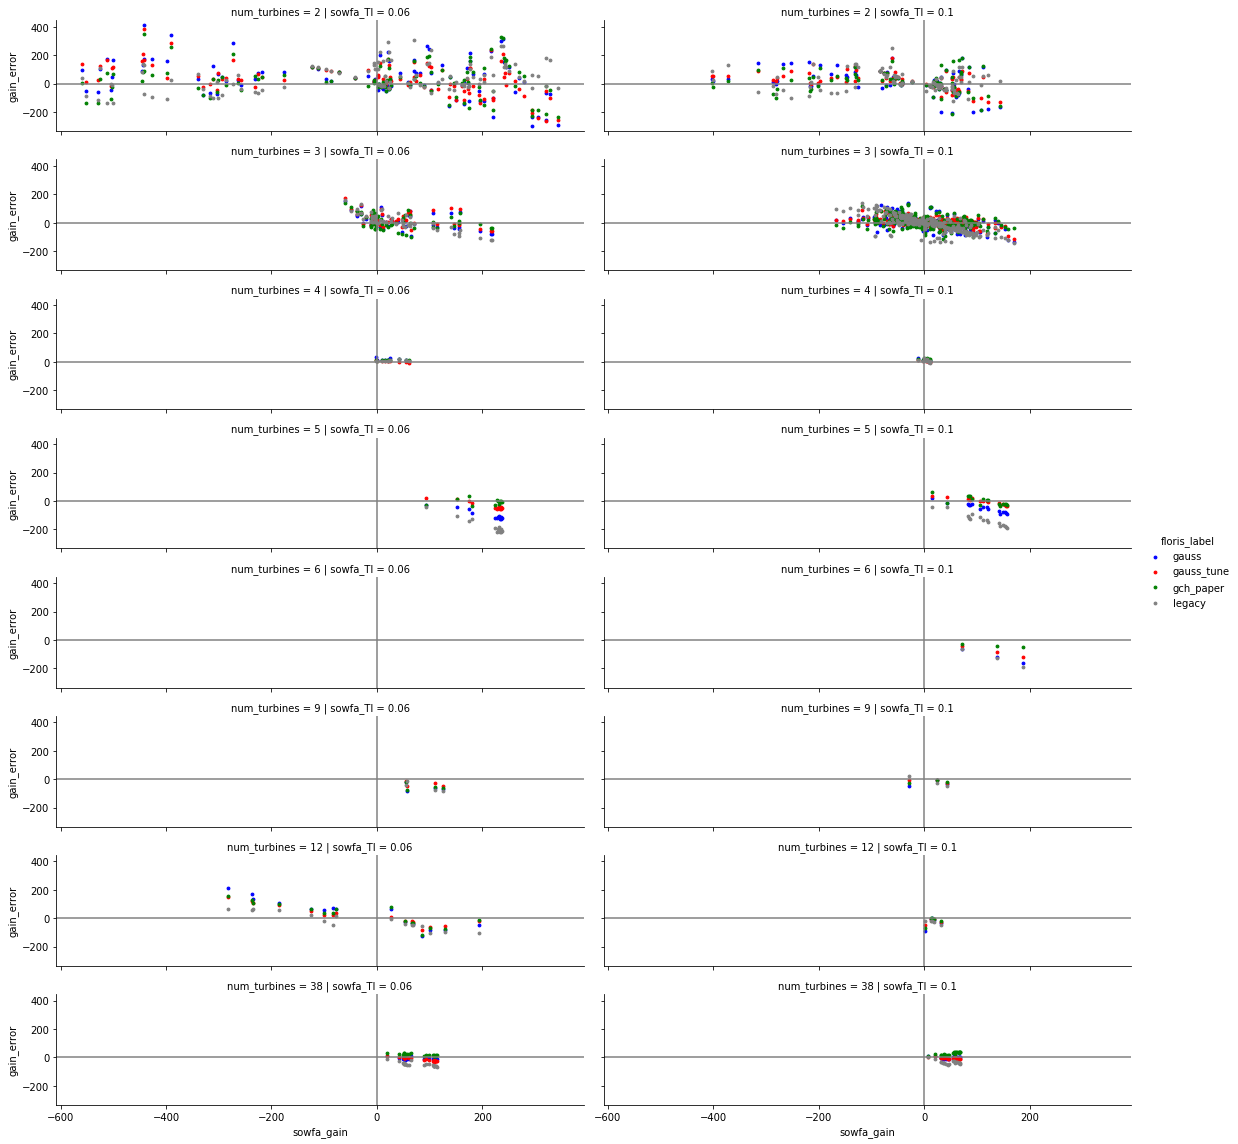

In [16]:
# Compare in terms of error
results_df['gain_error'] = results_df.floris_gain - results_df.sowfa_gain

g = sns.FacetGrid(results_df, row='num_turbines',col='sowfa_TI',hue='floris_label',palette=color_dict,aspect=4,size=2)
g.map(plt.scatter,sowfa_signal,'gain_error',s=8)
for ax in g.axes.flatten():
#     ax.plot([results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],
#             [results_df[sowfa_signal].min(),results_df[sowfa_signal].max()],'k--')
    ax.axhline(0,color='gray')
    ax.axvline(0,color='gray')
g.add_legend()

In [12]:
## Look at RMS error
# Check for an overall bias and rms
results_df[['gain_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])



gain_error                     
                   mean    median   <lambda>
floris_label                                
gauss          6.040751 -0.243500  75.853864
gauss_tune    12.027136  7.018541  59.093651
gch_paper      9.572672  7.127876  65.619215
legacy        -3.092608 -5.327304  75.508715

In [13]:
results_df[['gain_error','floris_label','num_turbines']].groupby(['floris_label','num_turbines']).agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])


gain_error                        
                                 mean      median    <lambda>
floris_label num_turbines                                    
gauss        2              26.512585   18.404972  115.226695
             3               2.642717   -0.164208   43.938818
             4              14.882815   13.230184   16.698243
             5             -69.456309  -73.203078   79.903774
             6            -113.236880 -118.059151  119.665411
             9             -47.323187  -48.476066   53.489732
             12             18.794952   -5.224282   90.036959
             38             -4.761157   -5.718243    9.321898
gauss_tune   2              22.889726   21.853781   91.209816
             3              13.112094   10.727110   36.863891
             4               5.224103    4.922966    7.417226
             5             -15.140512  -14.768206   32.018110
             6             -84.113286  -87.087752   90.166886
             9             -25.061486  -25.149266   29.017214
             12             12.267495   -3.249504   62.165698
             38             -8.805969   -7.021066   13.941297
gch_paper    2              17.324451   10.622882   99.691943
             3               4.512870   -0.529516   43.473638
             4              15.327267   13.416699   16.455074
             5              -2.016169   -3.012854   25.513016
             6             -40.923795  -43.177020   41.795253
             9             -39.863133  -29.431965   47.121546
             12             16.227021    2.898922   72.748332
             38             22.494973   20.036638   24.132896
legacy       2              32.229443   18.015025   91.180679
             3              -3.683485    0.799808   57.797049
             4               8.014075    5.670759   11.376406
             5            -148.063411 -153.155439  156.880205
             6            -125.666100 -129.157617  136.136426
             9             -37.600054  -37.546919   50.120833
             12            -18.753746  -22.312506   54.462947
             38            -42.119236  -43.180101   44.270109